## 1. Make classification data and get it ready

In [26]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [27]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [28]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                        })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [29]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

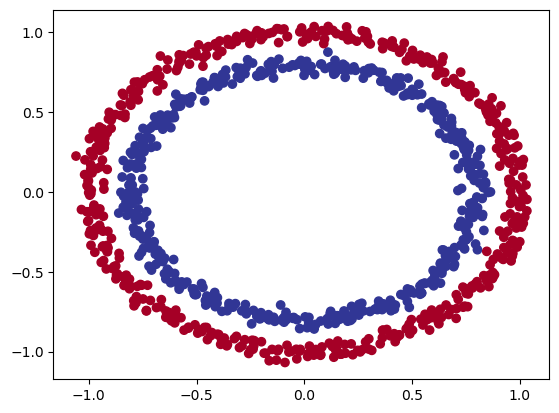

In [30]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

Note: This dataset is often what's considered a **toy problem** (a problem that's used to try and test things out on) in machine learning.

But it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify it, in our case, separate it into red or blue dots.

### 1.1 Input and output shapes

In [31]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [32]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

We have two inputs for one output.

### 1.2 Turn data into tensors and create train and test splits

In [33]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
from torch import nn

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [34]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [35]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [36]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

The only major change is what's happening between self.layer_1 and self.layer_2.

self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5.

This is known as having 5 hidden units or neurons.

This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

That's why self.layer_2 has in_features=5, it takes the out_features=5 from self.layer_1 and performs a linear computation on them, turning them into out_features=1 (the same shape as y).

In [38]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)


Woah, that looks much simpler than subclassing nn.Module, why not just always use nn.Sequential?

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

Now we've got a model, let's see what happens when we pass some data through it.

In [39]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.9080],
        [1.1242],
        [0.3702],
        [1.0603],
        [0.4159],
        [0.5475],
        [1.1199],
        [0.9850],
        [0.3691],
        [1.1392]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

- **SGD Optimizer**:
  - For classification, regression, and more.
  - Code: `torch.optim.SGD()`

- **Adam Optimizer**:
  - For classification, regression, and more.
  - Code: `torch.optim.Adam()`

- **Binary Cross Entropy Loss**:
  - For binary classification.
  - Code: `torch.nn.BCELoss` or `torch.nn.BCEWithLogitsLoss`

- **Cross Entropy Loss**:
  - For multi-class classification.
  - Code: `torch.nn.CrossEntropyLoss`

- **Mean Absolute Error (MAE) Loss**:
  - For regression.
  - Code: `torch.nn.L1Loss`

- **Mean Squared Error (MSE) Loss**:
  - For regression.
  - Code: `torch.nn.MSELoss`

Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

Note: Recall a loss function is what measures how wrong your model predictions are, the higher the loss, the worse your model.

Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

- **torch.nn.BCELoss()**:
  - Measures binary cross entropy between target (label) and input (features).
  - Requires a separate `nn.Sigmoid()` before applying loss.

- **torch.nn.BCEWithLogitsLoss()**:
  - Combines sigmoid activation and binary cross entropy in one step.
  - More numerically stable than BCELoss with separate sigmoid.

- **Recommendation**:
  - Use **BCEWithLogitsLoss()** in most cases for better stability.
  - Separate sigmoid and BCELoss for advanced use cases.

In [40]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

In [42]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

Forward pass - The model goes through all of the training data once, performing its forward() function calculations `(model(x_train))`.

Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are `(loss = loss_fn(y_pred, y_train)`.

Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step `(optimizer.zero_grad())`.

Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards" (`loss.backward()`).

Step the optimizer (gradient descent) - Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them (`optimizer.step()`).

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [44]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
print(y_logits)

tensor([[0.9080],
        [1.1242],
        [0.3702],
        [1.0603],
        [0.4159]], device='cuda:0', grad_fn=<SliceBackward0>)


Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method.

Which implements two layers of nn.Linear() which internally calls the following equation:

y = x.w^T + b

The raw outputs (unmodified) of this equation ($y$) and in turn, the raw outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data ($x$ in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

In [46]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.7126],
        [0.7548],
        [0.5915],
        [0.7428],
        [0.6025]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of prediction probabilities (I usually refer to these as y_pred_probs), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

- If y_pred_probs >= 0.5, y=1 (class 1)
- If y_pred_probs < 0.5, y=0 (class 0)

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [47]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [48]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our model's predictions to the test labels to see how well it's performing.

To recap, we converted our model's raw outputs (logits) to prediction probabilities using a sigmoid activation function.

And then converted the prediction probabilities to prediction labels by rounding them.

Note: The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function (this will come later on).

And the use of the sigmoid activation function is not required when passing our model's raw outputs to the nn.BCEWithLogitsLoss (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

### 3.2 Building a training and testing loop

In [49]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.75643, Accuracy: 50.00% | Test loss: 0.77209, Test acc: 50.00%
Epoch: 10 | Loss: 0.71811, Accuracy: 53.62% | Test loss: 0.73119, Test acc: 53.50%
Epoch: 20 | Loss: 0.70376, Accuracy: 55.50% | Test loss: 0.71461, Test acc: 50.50%
Epoch: 30 | Loss: 0.69822, Accuracy: 53.12% | Test loss: 0.70738, Test acc: 49.00%
Epoch: 40 | Loss: 0.69598, Accuracy: 52.38% | Test loss: 0.70390, Test acc: 48.00%
Epoch: 50 | Loss: 0.69499, Accuracy: 51.50% | Test loss: 0.70199, Test acc: 47.00%
Epoch: 60 | Loss: 0.69450, Accuracy: 51.50% | Test loss: 0.70080, Test acc: 46.00%
Epoch: 70 | Loss: 0.69422, Accuracy: 51.00% | Test loss: 0.69998, Test acc: 47.00%
Epoch: 80 | Loss: 0.69403, Accuracy: 50.75% | Test loss: 0.69935, Test acc: 45.50%
Epoch: 90 | Loss: 0.69389, Accuracy: 50.88% | Test loss: 0.69885, Test acc: 46.00%


The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

## 4. Make predictions and evaluate the model

In [50]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


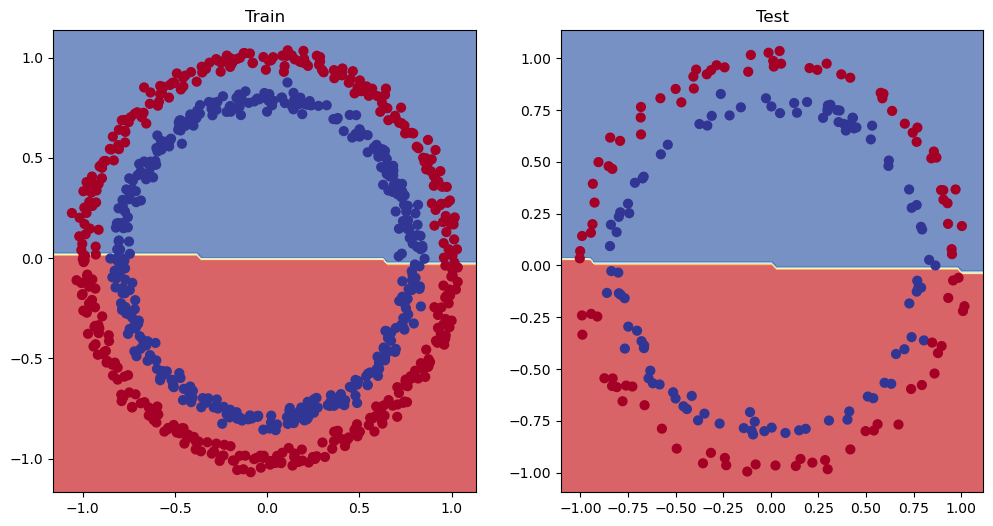

In [51]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

## 5. Improving a model (from a model perspective)

- **Add more layers**:
  - Increases model's ability to learn complex patterns.
  - Makes the network "deeper."

- **Add more hidden units**:
  - Increases model’s learning capacity within each layer.
  - Makes the network "wider."

- **Fitting for longer (more epochs)**:
  - Allows the model to learn more by seeing the data multiple times.

- **Changing activation functions**:
  - Helps the model handle complex, non-linear patterns.

- **Change the learning rate**:
  - Controls how much the model changes during training.
  - Too high: model overcorrects; too low: model learns too slowly.

- **Change the loss function**:
  - Different problems need different loss functions (e.g., binary vs multi-class).

- **Use transfer learning**:
  - Use a pre-trained model and adjust it for your own problem.

Note: *because you can adjust all of these by hand, they're referred to as hyperparameters.

And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

In [52]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [53]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)